# 6. Application of supervised learning

## Imports

In [87]:
import os
import warnings
from datetime import datetime, timedelta
from typing import Optional

import geopandas as gpd
import keras.layers
import keras.losses
import keras.models
import keras.optimizers
import keras.preprocessing
import keras.regularizers
import keras.utils
import lime
import lime.lime_tabular
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.figure
import matplotlib.pyplot as plt
import meteostat
import numpy as np
import optuna
import pandas as pd
import sklearn.ensemble
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.svm
from tqdm import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

## Dataset

### Presentation

The dataset deals with Forest Fires in France during the year 2023. It comes from data made available by the government and can be easily downloaded from the website https://bdiff.agriculture.gouv.fr/incendies. I found it while browsing the website https://www.data.gouv.fr/.

This dataset contains information such as the location of the fire (department and city), the date the fire started, the accuracy of the data, the areas affected including forest areas, agricultural areas, and non-natural areas. It details the number of deaths caused, the number of buildings destroyed, and provides information on the type of vegetation affected. Indeed, the value "Type de peuplement" refers to heaths, garrigues, maquis/scrub/deciduous forests/coniferous forests/mixed forests/regeneration and reforestation.

The dataset also includes information on the weather such as temperature, wind direction and wind speed. However, since this information is very rare (more that 90% of these information are lacking), we chose to enrich our dataset by retrieving weather information using the "meteostats" module. You only need the geographical coordinates of a location (its latitude and longitude) and the date to obtain the associated weather information.

You can find additionnal information of the dataset in the PDF file that have been downloaded along the CSV file.

### Goals

Another piece of information that quickly caught our interest is the "Nature" of the fire. This can correspond to five different values:

- "Naturelle": in the case of a fire not caused by direct or indirect human activity. This includes fires triggered by lightning, for example.
- "Accidentelle": in the case of a fire caused indirectly by a human event or installation. This includes fires that have started due to a power line rupture or vehicle exhausts.
- "Malveillance": in the case of a fire caused intentionally.
- "Involontaire  (travaux)": in the case of a fire caused by human activities in the context of professional activities but without the intention of starting a fire. This includes forest work, agricultural work, or construction work.
- "Involontaire  (particulier)": in the case of a fire caused by human activities related to private activities (construction work, DIY) or leisure activities, but without the intention of starting a fire.

Thus, the objective will be to attempt to predict the nature of a fire based on the previously described information. If the task proves to be too complex, the classification can guide statistical analyses by indicating which information is most useful for prediction.

These predictions and analyses can be very useful for investigations such as the "RCCI," which stands for "Recherche des Causes et des Circonstances de l'Incendie" (Investigation of the Causes and Circumstances of the Fire).
These predictions, along with their confidence levels, could discourage or encourage the initiation of such investigations.

### Load data from download from https://bdiff.agriculture.gouv.fr/incendies

In [6]:
dfb = pd.read_csv("data/incendies/Incendies.csv", header=2, sep=";")
dfb["Date de première alerte"] = pd.to_datetime(dfb["Date de première alerte"])

ORIGINAL_SIZE = dfb.shape[0]

dfb

,Année,Numéro,Département,Code INSEE,Nom de la commune,Date de première alerte,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),...,Intervention de l'équipe RCCI,Décès ou bâtiments touchés,Nombre de décès,Nombre de bâtiments totalement détruits,Nombre de bâtiments partiellement détruits,Hygrométrie (%),Vitesse moyenne du vent (Km/h),Direction du vent,Température (°C),Précision de la donnée
0,2023,9664,2B,2B046,Cagnano,2023-01-01 10:05:00,100,0.0,100.0,0.0,...,Non,Non,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023,9282,88,88148,Dommartin-lès-Remiremont,2023-01-01 15:29:00,2,2.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023,17212,40,40132,Labatut,2023-01-01 17:54:00,1000,1000.0,NaN,0.0,...,NaN,Non,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,2023,22382,64,64271,Iholdy,2023-01-01 18:11:35,10000,10000.0,NaN,0.0,...,NaN,Non,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,2023,21346,83,83152,Rayol-Canadel-sur-Mer,2023-01-02 20:59:00,35,0.0,35.0,0.0,...,Non,Non,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Données partielles ou non valides
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,2023,21902,83,83069,Hyères,2023-12-27 17:58:00,100,0.0,100.0,0.0,...,Non,Non,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Données partielles ou non valides
2668,2023,13754,07,07275,Saint-Mélany,2023-12-28 11:58:00,100,0.0,100.0,0.0,...,Non,Non,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2669,2023,21903,83,83110,Rougiers,2023-12-28 17:24:00,4,0.0,4.0,0.0,...,Non,Non,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Données partielles ou non valides
2670,2023,21904,83,83036,Cavalaire-sur-Mer,2023-12-29 07:22:00,60,60.0,0.0,0.0,...,Non,Non,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Données partielles ou non valides


### Add longitude and lagitude, dataset downloaded from https://download.geonames.org/export/dump/

In [10]:
column_names_loc = [
    "country",
    "Code INSEE",
    "City",
    "Région",
    "Unknown",
    "Departement",
    "Département Code",
    "Unknown2",
    "Unknown3",
    "lattitude",
    "longitude",
    "Unknown4",
]
df_lat_long = pd.read_csv("data/location/FR.txt", header=2, sep="\t", names=column_names_loc)
df_lat_long

,country,Code INSEE,City,Région,Unknown,Departement,Département Code,Unknown2,Unknown3,lattitude,longitude,Unknown4
0,FR,75002,Paris 02,Île-de-France,11.0,Paris,75,Paris,751,48.8655,2.3426,5
1,FR,75002,Paris,Île-de-France,11.0,Paris,75,Paris,751,48.8534,2.3488,5
2,FR,75003,Paris,Île-de-France,11.0,Paris,75,Paris,751,48.8534,2.3488,5
3,FR,75003,Paris 03,Île-de-France,11.0,Paris,75,Paris,751,48.8637,2.3615,5
4,FR,75004,Paris 04,Île-de-France,11.0,Paris,75,Paris,751,48.8601,2.3507,5
...,...,...,...,...,...,...,...,...,...,...,...,...
51669,FR,20601 CEDEX,Bastia,Corse,94.0,Haute-Corse,2B,Bastia,2B2,42.7022,9.4512,5
51670,FR,20604 CEDEX,Bastia,Corse,94.0,Haute-Corse,2B,Bastia,2B2,42.7022,9.4512,5
51671,FR,20611 CEDEX,Bastia,Corse,94.0,Haute-Corse,2B,Bastia,2B2,42.7022,9.4512,5
51672,FR,20620,Biguglia,Corse,94.0,Haute-Corse,2B,Bastia,2B2,42.6269,9.4202,5


In [11]:
# add lacking city by the location of a city near (of the same departement)
lacking_cities = dfb[~dfb["Nom de la commune"].isin(df_lat_long["City"])]
for _, row in tqdm(lacking_cities.iterrows(), total=lacking_cities.shape[0], desc="Add lat and long of lacking cities"):
    df2 = df_lat_long[df_lat_long["Département Code"] == row["Département"]].copy()
    if df2.shape[0] > 0:
        df2["City"] = row["Nom de la commune"]
    else:
        mapper = {"974": (-21.114533, 55.532062), "976": (-12.824511, 45.165455)}
        lat, lon = mapper[row["Département"]]
        df2 = pd.DataFrame(
            [
                {
                    "lattitude": -21.114533,
                    "longitude": 55.532062,
                    "City": row["Nom de la commune"],
                }
            ],
            columns=column_names_loc,
        )
    df_lat_long = pd.concat([df_lat_long, df2.iloc[:1]])

# remove duplicate
print("remove duplicate df_lat_long")
df_lat_long = df_lat_long.groupby(by="City").first().reset_index()

Add lat and long of lacking cities: 100%|██████████| 75/75 [00:00<00:00, 157.96it/s]


remove duplicate df_lat_long


In [12]:
# merge so that the original dataset have lattitude and longitude as columns
dfb2 = pd.merge(left=dfb, right=df_lat_long[["lattitude", "longitude", "City"]], left_on="Nom de la commune", right_on="City", how="inner", validate="many_to_one")
dfb2.drop(columns=["City"], inplace=True)

dfb2

,Année,Numéro,Département,Code INSEE,Nom de la commune,Date de première alerte,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),...,Nombre de décès,Nombre de bâtiments totalement détruits,Nombre de bâtiments partiellement détruits,Hygrométrie (%),Vitesse moyenne du vent (Km/h),Direction du vent,Température (°C),Précision de la donnée,lattitude,longitude
0,2023,9664,2B,2B046,Cagnano,2023-01-01 10:05:00,100,0.0,100.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.8783,9.4537
1,2023,9282,88,88148,Dommartin-lès-Remiremont,2023-01-01 15:29:00,2,2.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.9990,6.6405
2,2023,17212,40,40132,Labatut,2023-01-01 17:54:00,1000,1000.0,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,43.5507,-0.9845
3,2023,22382,64,64271,Iholdy,2023-01-01 18:11:35,10000,10000.0,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,43.2826,-1.1808
4,2023,21346,83,83152,Rayol-Canadel-sur-Mer,2023-01-02 20:59:00,35,0.0,35.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Données partielles ou non valides,43.1667,6.4667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,2023,21902,83,83069,Hyères,2023-12-27 17:58:00,100,0.0,100.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Données partielles ou non valides,43.1204,6.1286
2668,2023,13754,07,07275,Saint-Mélany,2023-12-28 11:58:00,100,0.0,100.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,44.5299,4.1183
2669,2023,21903,83,83110,Rougiers,2023-12-28 17:24:00,4,0.0,4.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Données partielles ou non valides,43.3923,5.8511
2670,2023,21904,83,83036,Cavalaire-sur-Mer,2023-12-29 07:22:00,60,60.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Données partielles ou non valides,43.1726,6.5296


### Get stats of the meteo with the module "meteostats"

In [13]:
columns = {
    'temp': 'temperature',
    'dwpt': 'dew_point',
    'rhum': 'relative_humidity',
    'prcp': 'precipitation',
    'snow': 'snowfall',
    'wdir': 'wind_direction',
    'wspd': 'wind_speed',
    'wpgt': 'wind_gust',
    'pres': 'pressure',
    'tsun': 'sunshine_duration',
    'coco': 'weather_code'
}

def get_meteo_stat(lattitude: float, longitude: float, date: datetime, name : Optional[str] = None) -> pd.DataFrame:

    if name:
        print(name)

    point = meteostat.Point(lat=lattitude, lon=longitude)

    data = meteostat.Hourly(point, date - timedelta(hours=24), date)
    data = data.fetch()
    if data.shape[0] != 0:
        # return the closest hour
        return data.iloc[-1:]
    
    # if no data found, add an empty line
    data = pd.DataFrame([[np.nan] * len(columns.keys())], columns=columns)
    data.index.name = "time"
    return data
    

df_meteostats = [
    get_meteo_stat(
        lattitude=row["lattitude"],
        longitude=row["longitude"],
        date=row["Date de première alerte"],
    )
    for _, row in tqdm(dfb2.iterrows(), total=dfb2.shape[0])
]
df_meteostats = pd.concat(df_meteostats).reset_index()

# rename columns
df_meteostats.rename(columns=columns, inplace=True)
df_meteostats.rename(columns={"time" : "time_meteostats"}, inplace=True)

df_meteostats

100%|██████████| 2672/2672 [00:55<00:00, 48.58it/s]


,time_meteostats,temperature,dew_point,relative_humidity,precipitation,snowfall,wind_direction,wind_speed,wind_gust,pressure,sunshine_duration,weather_code
0,2023-01-01 10:00:00,14.1,12.3,89.0,0.0,NaN,190.0,27.7,18.5,1031.1,NaN,2.0
1,2023-01-01 15:00:00,15.0,6.8,58.0,0.0,NaN,172.0,11.1,29.6,1019.6,NaN,3.0
2,2023-01-01 17:00:00,21.0,1.8,28.0,0.0,NaN,200.0,16.6,NaN,1015.2,NaN,3.0
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-02 20:00:00,13.7,12.8,94.0,0.0,NaN,90.0,18.4,14.8,1027.0,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2667,2023-12-27 17:00:00,12.7,9.7,82.0,0.0,NaN,90.0,14.8,16.7,1025.9,NaN,2.0
2668,2023-12-28 11:00:00,8.3,7.2,93.0,0.0,NaN,170.0,3.6,NaN,1027.6,NaN,3.0
2669,2023-12-28 17:00:00,10.4,9.0,91.0,0.0,NaN,100.0,18.4,NaN,1025.7,NaN,3.0
2670,2023-12-29 07:00:00,9.0,6.6,85.0,0.0,NaN,280.0,9.4,16.7,1023.1,NaN,3.0


In [14]:
# add meteo stats in the main dataframe
df = pd.concat([dfb2, df_meteostats], axis=1)
df

,Année,Numéro,Département,Code INSEE,Nom de la commune,Date de première alerte,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),...,dew_point,relative_humidity,precipitation,snowfall,wind_direction,wind_speed,wind_gust,pressure,sunshine_duration,weather_code
0,2023,9664,2B,2B046,Cagnano,2023-01-01 10:05:00,100,0.0,100.0,0.0,...,12.3,89.0,0.0,NaN,190.0,27.7,18.5,1031.1,NaN,2.0
1,2023,9282,88,88148,Dommartin-lès-Remiremont,2023-01-01 15:29:00,2,2.0,NaN,0.0,...,6.8,58.0,0.0,NaN,172.0,11.1,29.6,1019.6,NaN,3.0
2,2023,17212,40,40132,Labatut,2023-01-01 17:54:00,1000,1000.0,NaN,0.0,...,1.8,28.0,0.0,NaN,200.0,16.6,NaN,1015.2,NaN,3.0
3,2023,22382,64,64271,Iholdy,2023-01-01 18:11:35,10000,10000.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023,21346,83,83152,Rayol-Canadel-sur-Mer,2023-01-02 20:59:00,35,0.0,35.0,0.0,...,12.8,94.0,0.0,NaN,90.0,18.4,14.8,1027.0,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,2023,21902,83,83069,Hyères,2023-12-27 17:58:00,100,0.0,100.0,0.0,...,9.7,82.0,0.0,NaN,90.0,14.8,16.7,1025.9,NaN,2.0
2668,2023,13754,07,07275,Saint-Mélany,2023-12-28 11:58:00,100,0.0,100.0,0.0,...,7.2,93.0,0.0,NaN,170.0,3.6,NaN,1027.6,NaN,3.0
2669,2023,21903,83,83110,Rougiers,2023-12-28 17:24:00,4,0.0,4.0,0.0,...,9.0,91.0,0.0,NaN,100.0,18.4,NaN,1025.7,NaN,3.0
2670,2023,21904,83,83036,Cavalaire-sur-Mer,2023-12-29 07:22:00,60,60.0,0.0,0.0,...,6.6,85.0,0.0,NaN,280.0,9.4,16.7,1023.1,NaN,3.0


## Preprocess

In [73]:
# parameters of the dataset
ONLY_KEEP_ACCURATE_DATA = True
ADD_INTERVENTION_RCCI = True
ADD_METEO_STATS = True

### Manage Nan values

In [9]:
# display the percentage of missing values for columns that have at least one missing value
def compute_percentage_na(df : pd.DataFrame) -> pd.Series:
    return df.isna().astype(int).sum(axis=0) / df.shape[0]
percentage_na = compute_percentage_na(df)
percentage_na[percentage_na > 0]

Surface forêt (m2)                                 0.000374
Surface maquis garrigues (m2)                      0.312500
Autres surfaces naturelles hors forêt (m2)         0.025075
Surfaces agricoles (m2)                            0.022455
Autres surfaces (m2)                               0.023952
Surface autres terres boisées (m2)                 1.000000
Surfaces non boisées naturelles (m2)               1.000000
Surfaces non boisées artificialisées (m2)          1.000000
Surfaces non boisées (m2)                          1.000000
Surface de feu à l'arrivée des secours > 0,1 ha    0.745135
Type de peuplement                                 0.684880
Connaissance de la cause                           0.013473
Nature                                             0.434880
Intervention de l'équipe RCCI                      0.329341
Décès ou bâtiments touchés                         0.013847
Nombre de décès                                    0.742889
Nombre de bâtiments totalement détruits 

In [142]:
# Décès ou bâtiments touchés : NaN => 'Non' (we consider that no information given means no destroyed building)
df.loc[df["Décès ou bâtiments touchés"].isna(), "Décès ou bâtiments touchés"] = (
    "Non"
)

# Type de peuplement : NaN => 0 (category 0 : Unknwown)
df.loc[df["Type de peuplement"].isna(), "Type de peuplement"] = 0
l = ["Unknown", "Landes,garrigues,maquis", "taillis", "futaies feuillues",  "futaies résineuses", "futaies mélangées", "régénération et reboisement"]
for i, name in enumerate(l):
    df.loc[df["Type de peuplement"] == i, "Type de peuplement"] = name

# Intervention de l'équipe RCCI : NaN => 'Non'
df.loc[df["Intervention de l'équipe RCCI"].isna(), "Intervention de l'équipe RCCI"] = (
    "Non"
)

# Surface parcourue (m2), Surface forêt (m2)... : NaN => 0
nan_to_zero = [
    "Surface parcourue (m2)",
    "Surface forêt (m2)",
    "Surface maquis garrigues (m2)",
    "Autres surfaces (m2)",
    "Autres surfaces naturelles hors forêt (m2)",
    "Surfaces agricoles (m2)",
    "Nombre de décès",
    "Nombre de bâtiments totalement détruits",
    "Nombre de bâtiments partiellement détruits",
    "weather_code", # weather_code=0 means clear sky 
    "snowfall",
]
for column in nan_to_zero:
    df.loc[df[column].isna(), column] = 0

# set values to its mean
nan_to_mean = [
    "temperature",
    "dew_point",
    "relative_humidity",
    "pressure",
    "precipitation",
    "wind_direction", # does not make very sense but mehhh
    "wind_speed"
]
for column in nan_to_mean:
    df.loc[df[column].isna(), column] = df[column].mean()

# drop columns that have too much NaN and that can't be replaced by a default value
df.drop(
    columns=[
        "Surface autres terres boisées (m2)",
        "Surfaces non boisées naturelles (m2)",
        "Surfaces non boisées artificialisées (m2)",
        "Surfaces non boisées (m2)",
        "Surface de feu à l'arrivée des secours > 0,1 ha",
        "Hygrométrie (%)",
        "Vitesse moyenne du vent (Km/h)",
        "Direction du vent",
        "Température (°C)",
        "sunshine_duration",
        "wind_gust"
    ],
    inplace=True,
    errors="ignore"
)

### Add columns from existing columns

In [88]:
# Add column : 'month'
df['month'] = df['Date de première alerte'].dt.month
# Add column : 'hour'
df['hour'] = df['Date de première alerte'].dt.hour

# Add all significations of wheather code
weather_codes = {
    "No significant weather or clear skies": (0, 19),
    "Precipitation but not reaching the ground": (20, 29),
    "Dust or sand": (30, 39),
    "Fog or mist": (40, 49),
    "Drizzle": (50, 59),
    "Rain": (60, 69),
    "Snow or ice pellets": (70, 79),
    "Showers, thunderstorms, and other significant weather events": (80, 99)
}
df["weather_code_category"] = None
for name, bounds in weather_codes.items():
    low, high = bounds
    df.loc[(low <= df["weather_code"]) & (df["weather_code"] <= high), "weather_code_category"] = name

### Filter

In [74]:
# Only keep accurate data
if ONLY_KEEP_ACCURATE_DATA:
    df = df[df["Précision de la donnée"] != "Données partielles ou non valides"]

df.loc[df["Précision de la donnée"].isna(), "Précision de la donnée"] = "Bonne"

# Only keep those who the nature of the fire ignition is known
df = df[df["Connaissance de la cause"] != "Inconnue"]
df = df[~df["Nature"].isna()]

print("Original size :    ", ORIGINAL_SIZE)
print("Size after filter :", df.shape[0])

Original size :     2672
Size after filter : 1257


## Analyses

<Axes: title={'center': 'Number of fire for each nature'}, xlabel='Nature'>

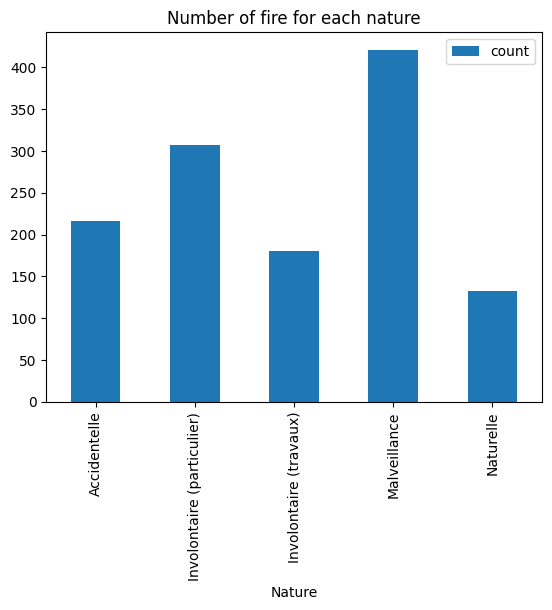

In [152]:
df.groupby(by="Nature").count().rename(columns={"Numéro": "count"})[["count"]].plot(kind="bar", title="Number of fire for each nature")

<Axes: xlabel='Année'>

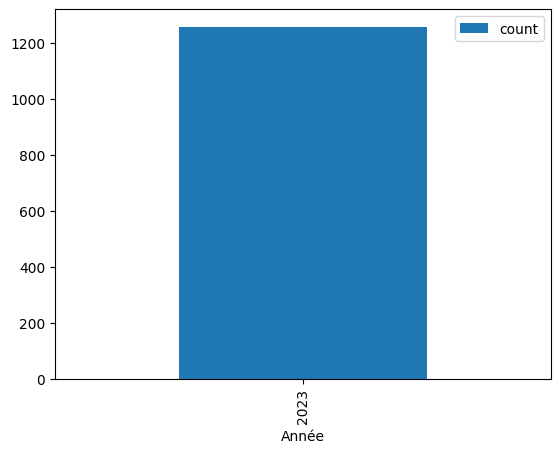

In [76]:
# just a reminder
df.groupby(by="Année").count().rename(columns={"Numéro": "count"})[["count"]].plot(kind="bar")

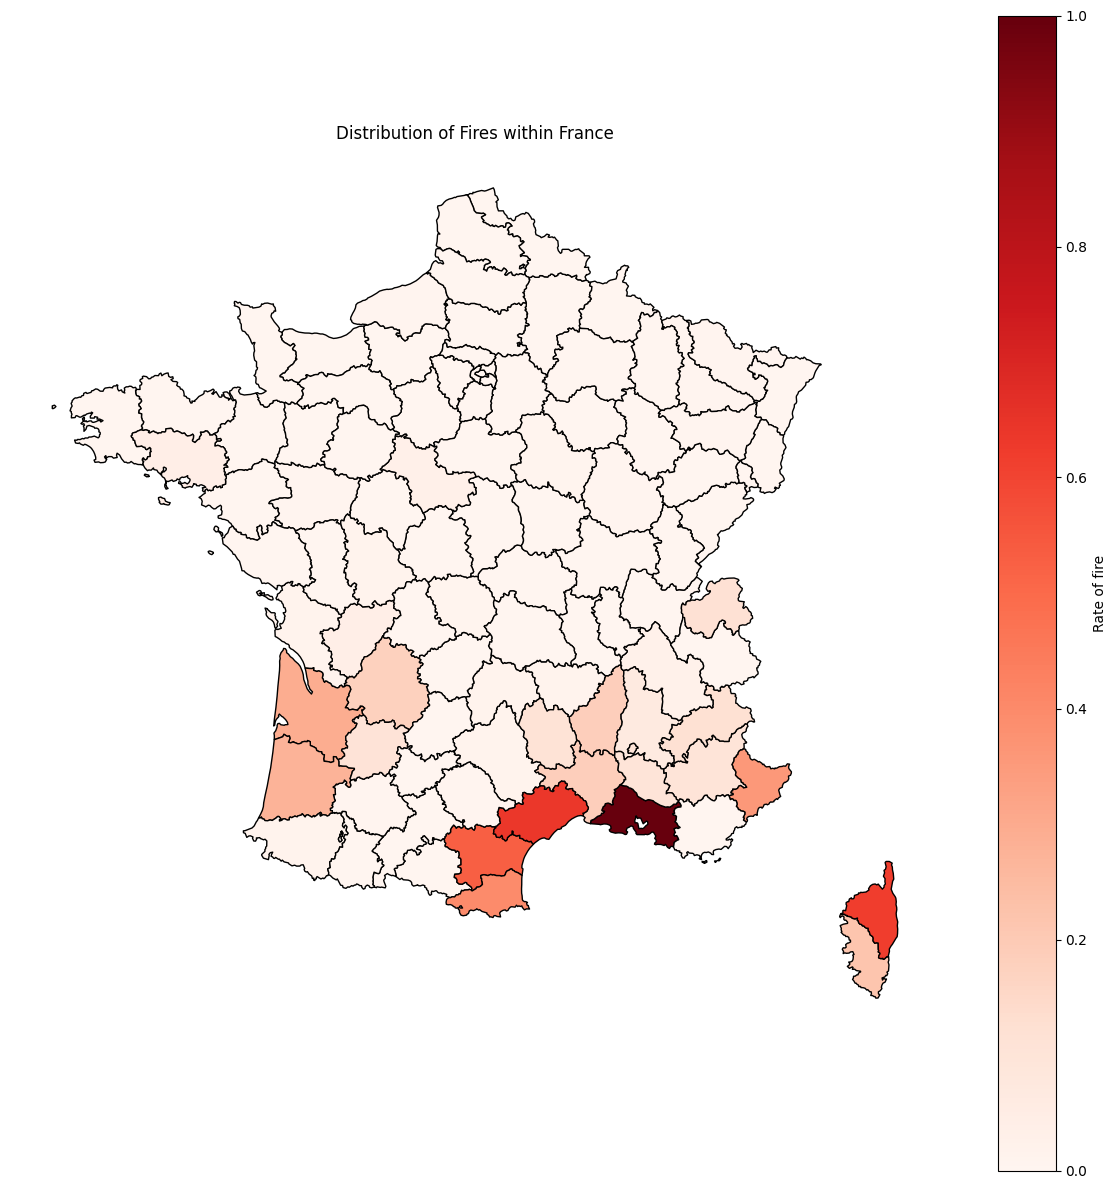

In [160]:

def plot_france(df : pd.DataFrame, fig : matplotlib.figure.Figure, ax : plt.Axes, title : str, last : bool = True) -> None:
    # Load the shapefile of France departments including DOM-TOM if available
    url = 'https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson'
    france = gpd.read_file(url)

    department_colors = {
        code : 0
        for code in france['code']
    }

    df2 = df.groupby(by="Département").count().rename(columns={"Numéro": "count"})[["count"]]
    df2 = (df2-df2.min())/(df2.max()-df2.min())
    for code, row in df2.iterrows():
        department_colors[code] = row["count"]

    # Create a color map that ranges from light red to dark red
    cmap = plt.cm.Reds

    for code, color in department_colors.items():
        department_colors[code] = cmap(color)

    # Plot the departments with the specified colors
    france.plot(ax=ax, color=list(department_colors.values()), edgecolor='black')
    ax.set_title(title)

    # Remove axes for better visual
    ax.set_axis_off()

    # Add a color bar to show the gradient scale
    if last:
        sm = plt.cm.ScalarMappable(cmap=cmap)
        cbar = fig.colorbar(sm, ax=ax)
        cbar.set_label('Rate of fire')

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
plot_france(df, fig, ax, "Distribution of Fires within France")

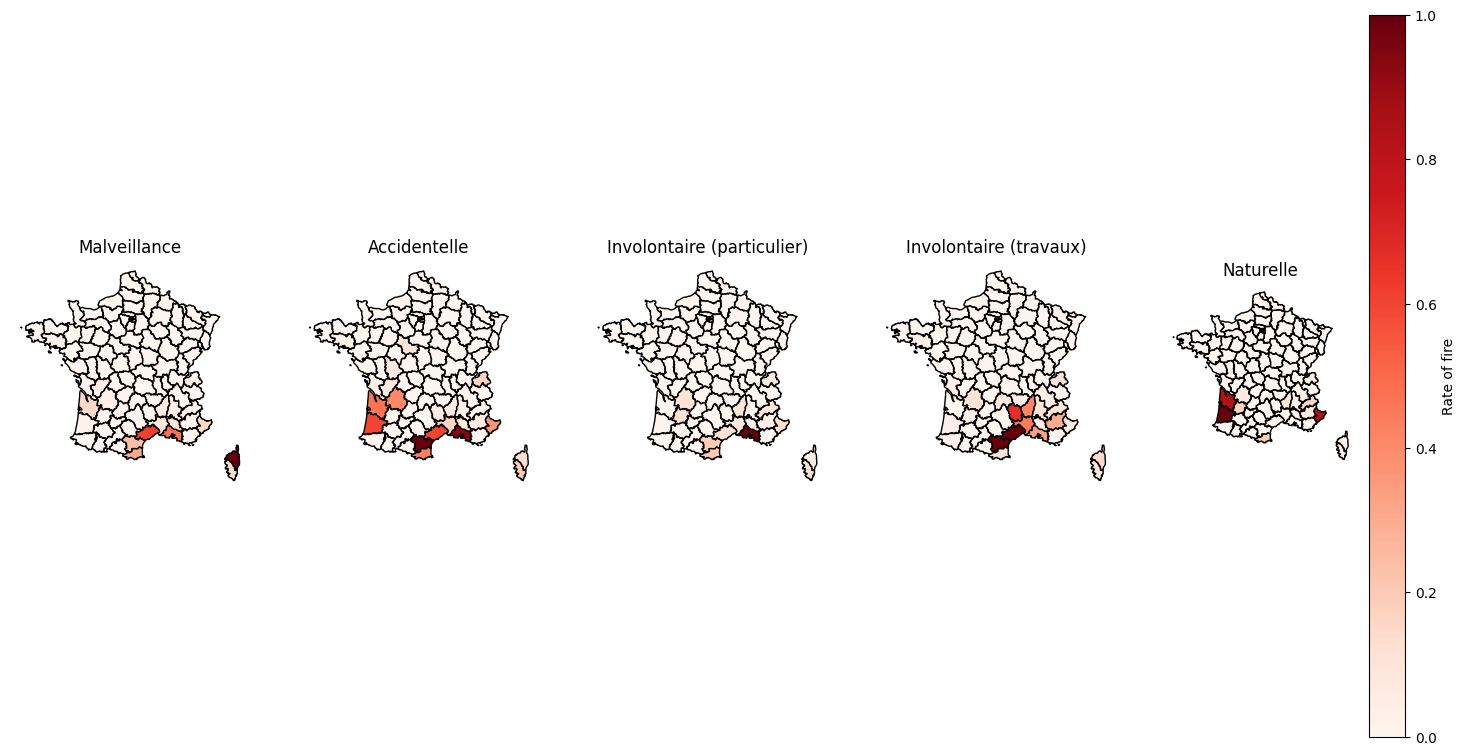

In [162]:
fig, axes = plt.subplots(1, df["Nature"].unique().shape[0], figsize=(18, 15))
for index, nature in enumerate(df["Nature"].unique()):
    plot_france(df[df["Nature"] == nature], fig, axes[index], nature, last=(index+1==df["Nature"].unique().shape[0]))

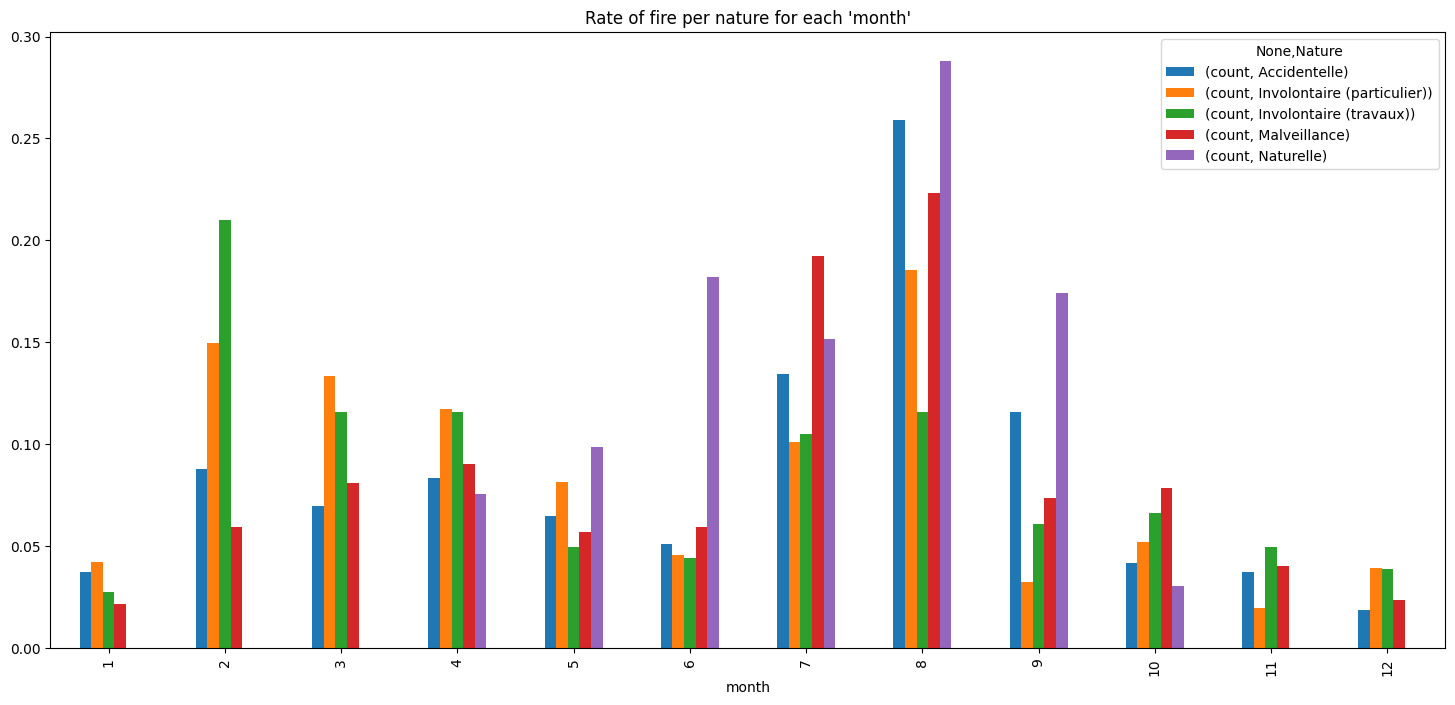

In [145]:
def display_column_per_nature(df : pd.DataFrame, column_name : str) -> None:
    df2 = (
        df.groupby(by=[column_name, "Nature"])
        .count()
        .rename(columns={"Numéro": "count"})[["count"]]
    )
    df2 = (
        df2
        / df.groupby(by=["Nature"]).count().rename(columns={"Numéro": "count"})[["count"]]
    )
    # for each nature, the num of the values equal to one
    df2.unstack("Nature").plot(
        kind="bar", title=f"Rate of fire per nature for each '{column_name}'", figsize=(18, 8)
    )
display_column_per_nature(df, "month")

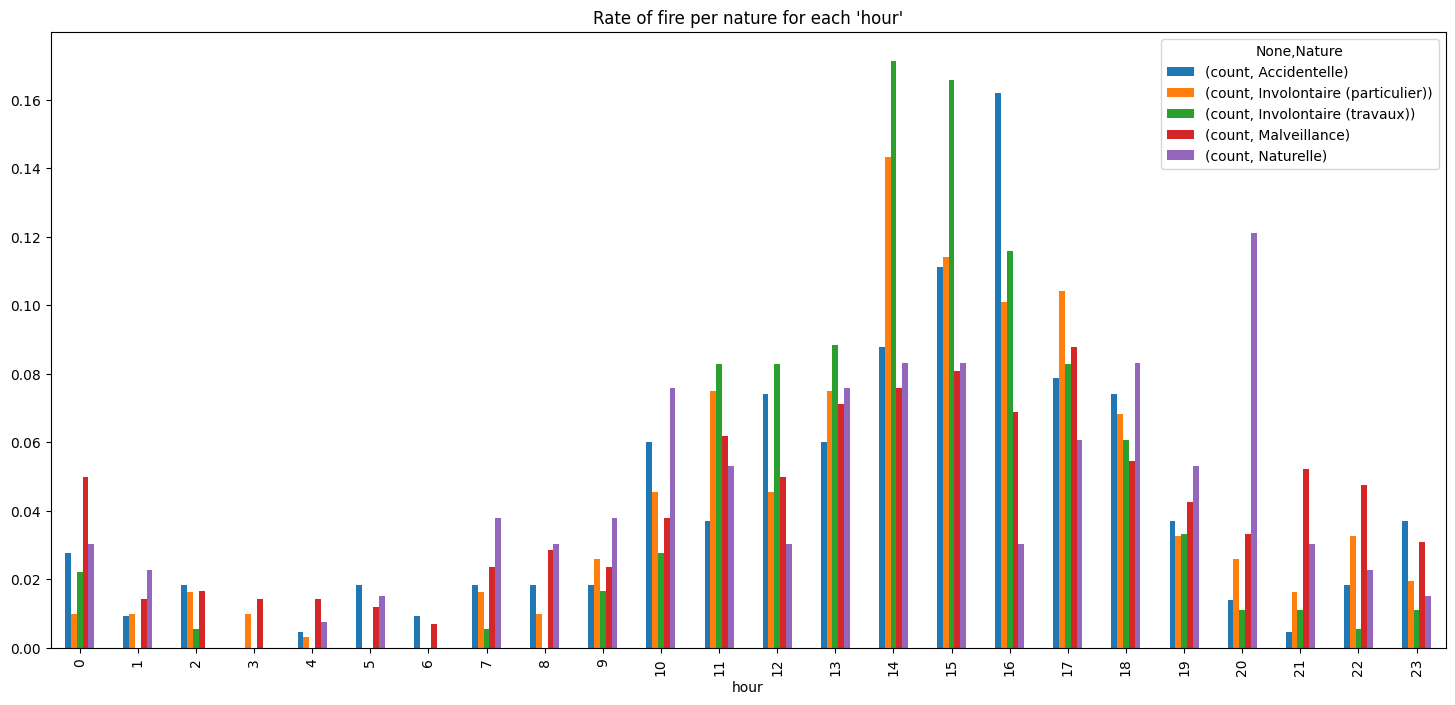

In [146]:
display_column_per_nature(df, "hour")

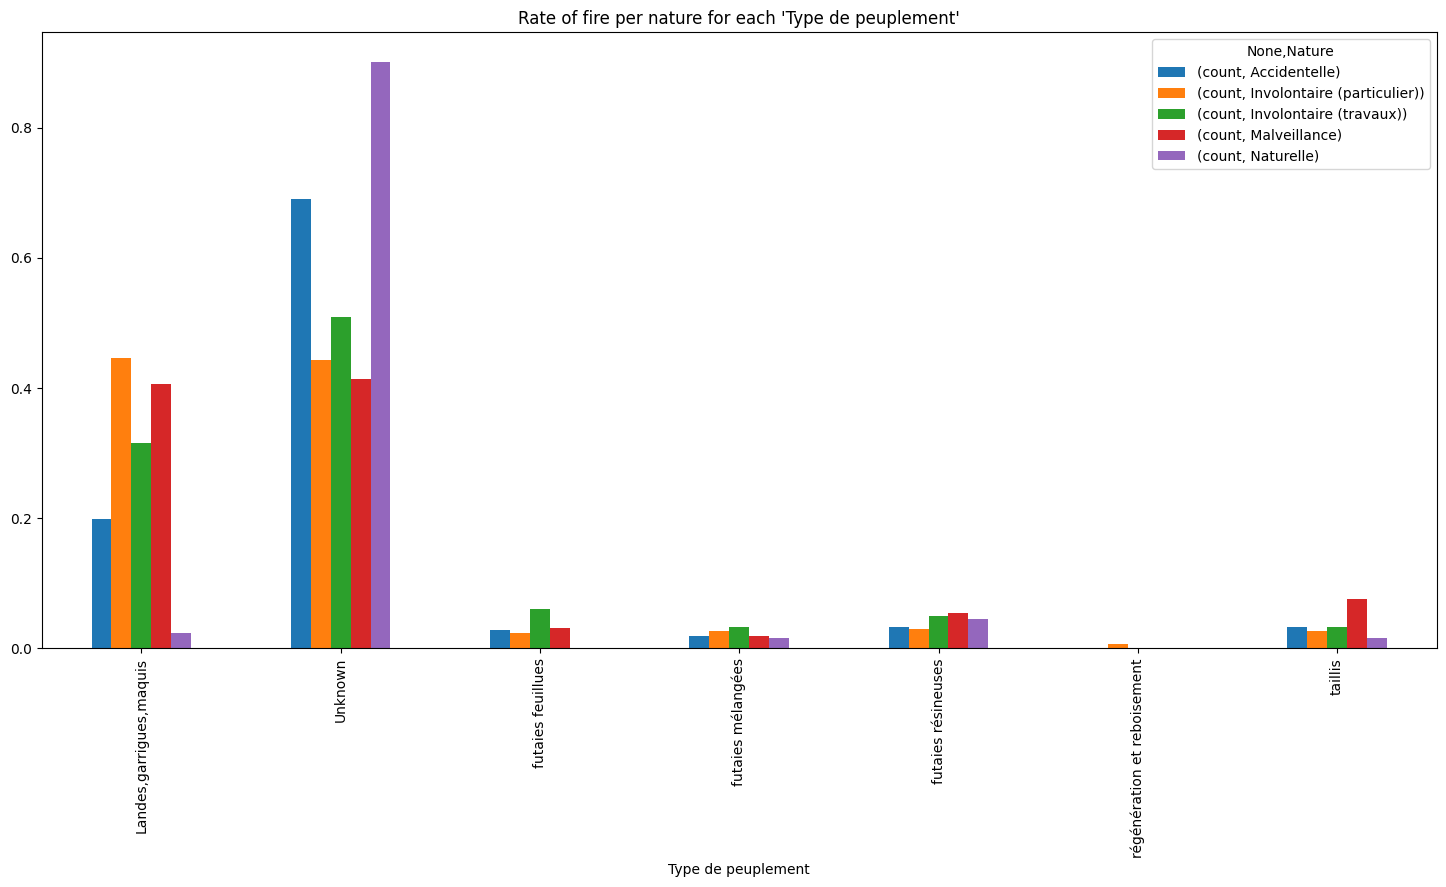

In [147]:
display_column_per_nature(df, "Type de peuplement")

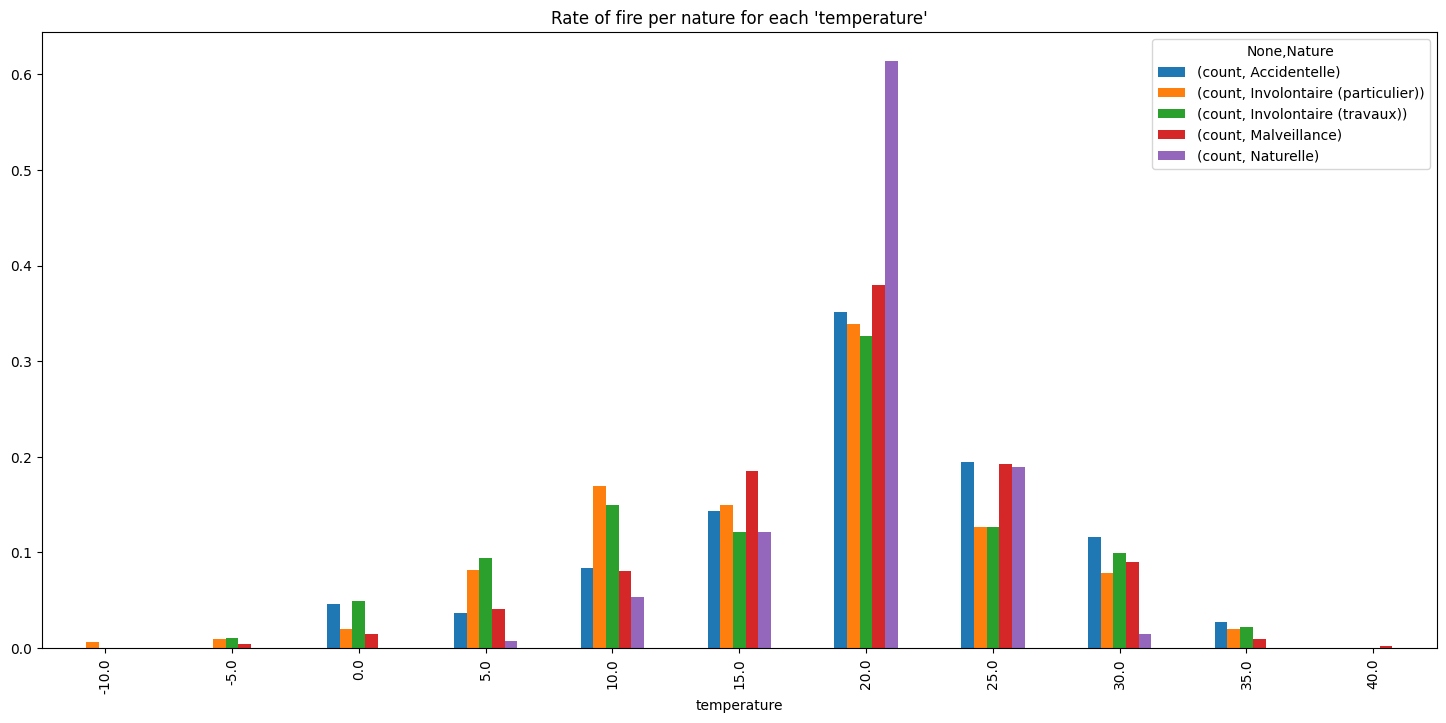

In [151]:
df2 = df.copy()
n = 5
df2["temperature"] = df2["temperature"] // n * 5 
display_column_per_nature(df2, "temperature")

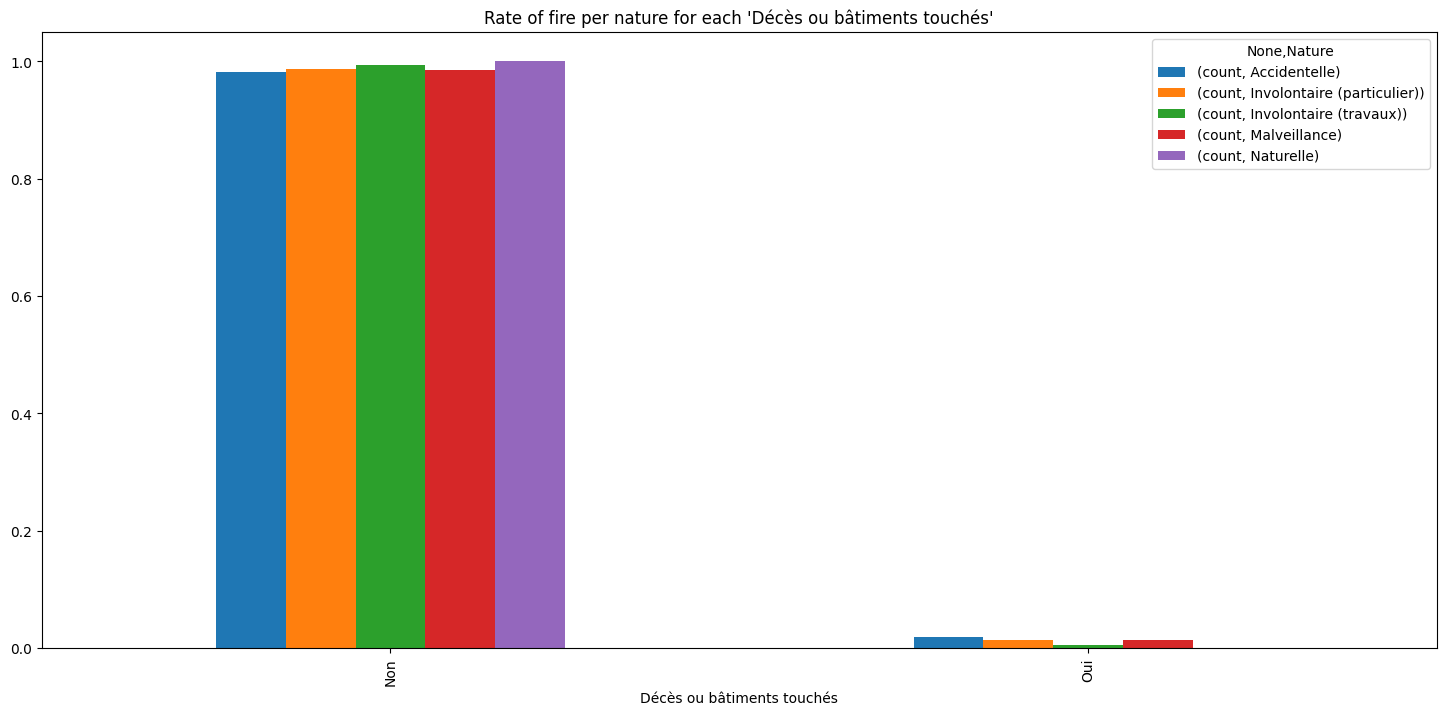

In [165]:
display_column_per_nature(df2, "Décès ou bâtiments touchés")

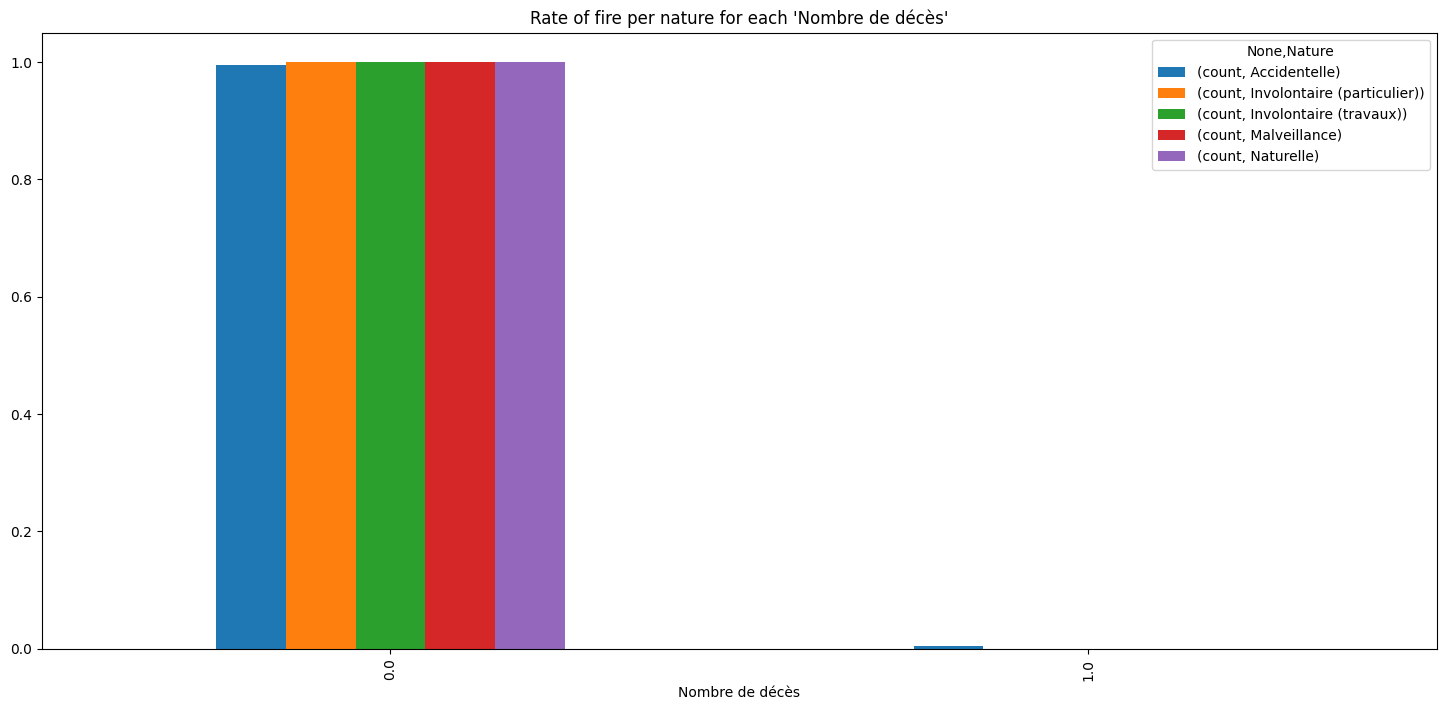

In [166]:
display_column_per_nature(df2, "Nombre de décès")


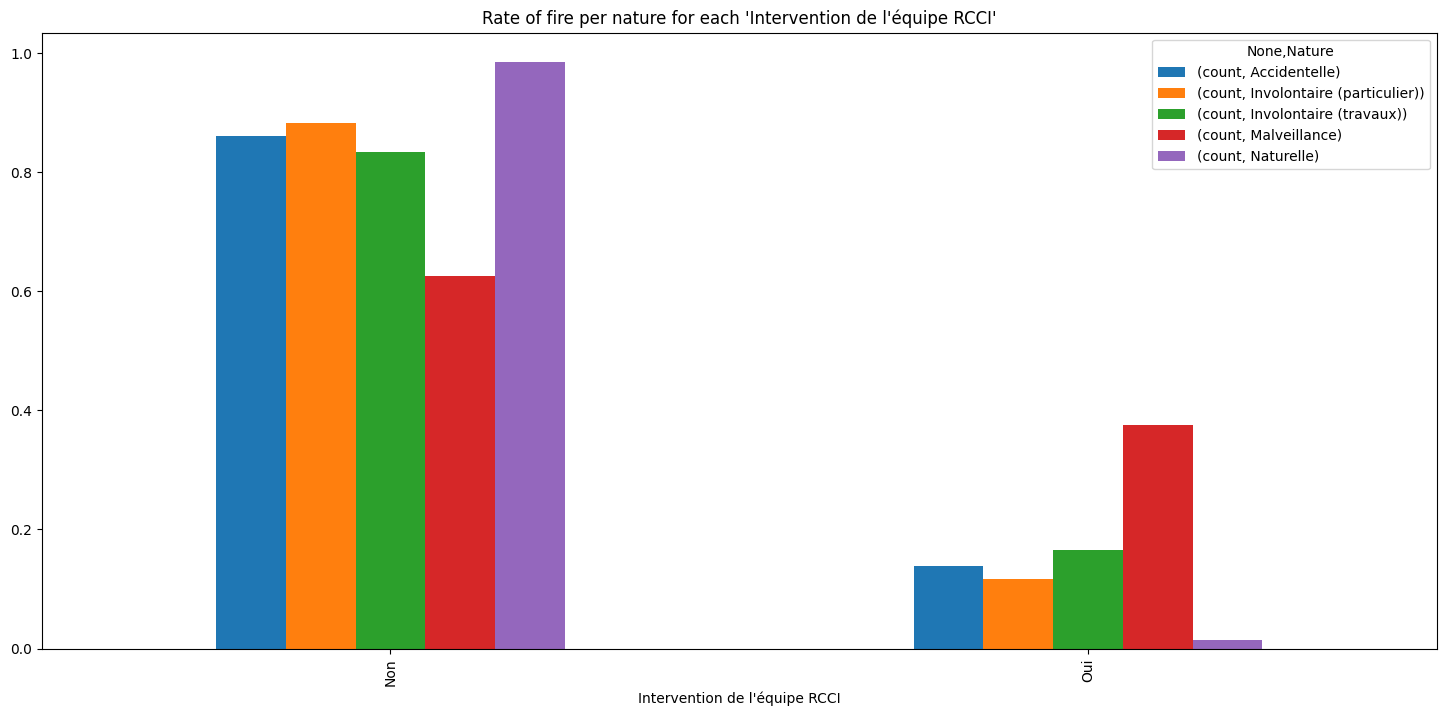

In [309]:
display_column_per_nature(df2, "Intervention de l'équipe RCCI")

### Analyses conclusion

Metrics per metrics :
- the dataset is well balanced, there is just a bit more of "Malveillance"
- southern regions have more fires
- "hautes-corses" has MANY "Malveillance" fire
- west-south have a lot of "Naturelle" fire
- "Naturelle" fire occurs beetween April and October
- People that create "Malveillance" fire are still people so they don't like to go outside when it is to hot
- there is almost 0 never destroyed buildings and poeple that die from the fire so these features should be useless
- there is more RCCI for "Malveillance" fire and less for "Naturelle" which is expected

The whole :
- the information of temperature may be repeated in multiple information like hour, month and the location
- the categories "Accidentelle", "Involontaire (particulier)" et "Involontaire (travaux)" does not seem to follow a pattern, they may seem random

## Classification

### Select features

In [341]:
ADD_METEO_STATS = True

features_one_hot_encoding = [
    "Département",
    # "Nom de la commune",
    "Précision des surfaces",
    "Type de peuplement",
    "Connaissance de la cause",
    "month",
    "hour",
]
if ADD_METEO_STATS:
    features_one_hot_encoding.extend(
        [
            "weather_code_category",
        ]
    )

features_yes_no = [
    "Décès ou bâtiments touchés",
]
if ADD_INTERVENTION_RCCI and True:
    features_yes_no.append("Intervention de l'équipe RCCI")

features = [
    "Surface parcourue (m2)",
    "Surface forêt (m2)",
    "Surface maquis garrigues (m2)",
    "Autres surfaces naturelles hors forêt (m2)",
    "Surfaces agricoles (m2)",
    "Nombre de décès",
    "Nombre de bâtiments totalement détruits",
]
if ADD_METEO_STATS:
    features.extend(
        [
            "temperature",
            "dew_point",
            "relative_humidity",
            "pressure",
            "precipitation",
            "wind_direction",
            "wind_speed",
            "snowfall",
        ]
    )

# display useful information
pd.DataFrame(
    {c: df[c].unique().shape for c in features_one_hot_encoding}, index=["Nb features of one hot encodings"]
).T

,Nb features of one hot encodings
Département,53
Précision des surfaces,2
Type de peuplement,7
Connaissance de la cause,2
month,12
hour,24
weather_code_category,2


### Construct dataset

In [342]:
# numeric features
X = df[features].copy()

# one hot encoding features
for column in features_one_hot_encoding:
    for value in np.sort(df[column].unique()):
        X[f"{column}_{value}"] = (df[column] == value).astype(int)

# no, yes features --> 0, 1
for column in features_yes_no:
    X[column] = df[column]
    X.loc[X[column] == "Non", column] = 0
    X.loc[X[column] == "Oui", column] = 1

# classes

label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(df["Nature"].unique())
y = label_encoder.transform(df["Nature"])

print("X.shape :", X.shape)
print("y.shape :", y.shape)
X

X.shape : (1257, 119)
y.shape : (1257,)


,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Nombre de décès,Nombre de bâtiments totalement détruits,temperature,dew_point,relative_humidity,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weather_code_category_No significant weather or clear skies,weather_code_category_Precipitation but not reaching the ground,Décès ou bâtiments touchés,Intervention de l'équipe RCCI
0,100,0.0,100.0,0.0,0.0,0.0,0.0,14.100000,12.300000,89.000000,...,0,0,0,0,0,0,1,0,0,0
2,1000,1000.0,0.0,0.0,0.0,0.0,0.0,21.000000,1.800000,28.000000,...,0,0,0,0,0,0,1,0,0,0
6,200,0.0,200.0,0.0,0.0,0.0,0.0,16.300000,9.200000,63.000000,...,0,0,0,0,0,0,1,0,0,0
7,5000,0.0,5000.0,0.0,0.0,0.0,0.0,18.400000,1.000000,31.000000,...,0,0,0,0,0,0,1,0,0,0
9,1000,1000.0,0.0,0.0,0.0,0.0,0.0,14.600000,9.600000,72.000000,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,61829,300.0,0.0,61529.0,0.0,0.0,0.0,20.743219,10.030561,53.814647,...,0,0,0,0,0,0,1,0,0,0
2662,97200,200.0,0.0,97000.0,0.0,0.0,0.0,20.743219,10.030561,53.814647,...,0,0,0,0,0,0,1,0,0,0
2663,500,0.0,500.0,0.0,0.0,0.0,0.0,6.900000,3.700000,80.000000,...,0,0,0,0,0,0,1,0,0,0
2668,100,0.0,100.0,0.0,0.0,0.0,0.0,8.300000,7.200000,93.000000,...,0,0,0,0,0,0,1,0,0,0


In [343]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.5, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((628, 119), (629, 119), (628,), (629,))

### Load model

In [344]:
clf = sklearn.ensemble.RandomForestClassifier()
clf = sklearn.svm.SVC()
clf = sklearn.linear_model.SGDClassifier()
clf = sklearn.linear_model.LogisticRegression(
        penalty="l1",
        solver="liblinear",
        C=10,
        # l1_ratio=l1_ratio,
        class_weight=None,
    )
clf = sklearn.ensemble.GradientBoostingClassifier()

def build_estimator(clf):
    return sklearn.pipeline.make_pipeline(
       sklearn.preprocessing.StandardScaler(),
        clf,
    )

def init_NN(regu1 : float = 0.0000000000001, regu2 : float = 0.000000000000):

    # regu1 = keras.regularizers.L2(regu1)
    # regu2 = keras.regularizers.L2(regu2)

    estimator = keras.models.Sequential([
        keras.layers.Input((X_train.shape[1],)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(5, activation='softmax') 
    ])
    estimator.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    estimator.summary()

    return estimator

# estimator = init_NN()
estimator = build_estimator(clf)

### Train

In [345]:
estimator.fit(X_train, y_train)
# estimator.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [346]:
if False:
    cv = sklearn.model_selection.ShuffleSplit(n_splits=5, test_size=0.3, random_state=1) 
    scores = sklearn.model_selection.cross_val_score(estimator, X, y, cv=cv, scoring="f1_macro")
    scores, scores.mean(), scores.std()

### Evaluate

Accuracy: 0.5468998410174881
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.32      0.34       110
           1       0.58      0.54      0.56       167
           2       0.49      0.41      0.45        92
           3       0.66      0.72      0.69       207
           4       0.43      0.57      0.49        53

    accuracy                           0.55       629
   macro avg       0.50      0.51      0.51       629
weighted avg       0.54      0.55      0.54       629



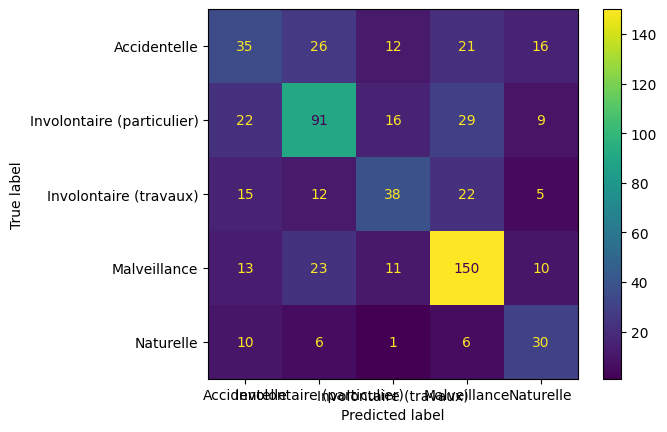

In [347]:
y_pred = estimator.predict(X_test)
if False:
    y_pred = y_pred.argmax(axis=1)
print(f"Accuracy: {sklearn.metrics.accuracy_score(y_test, y_pred)}")

print("Classification Report:")
print(sklearn.metrics.classification_report(y_test, y_pred))

disp = sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(y_test, y_pred), display_labels=label_encoder.classes_)
disp.plot()

## Optimize parameters

### Create the objectives function

In [200]:
def objective(estimator):

    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    return sklearn.metrics.f1_score(y_test, y_pred, average="macro")

def objective_lr(trial: optuna.trial.Trial): # 48% macro f1 score

    tol = trial.suggest_float("tol", 1e-12, 1e-2)
    # c = trial.suggest_float("C", 1e-12, 1e10)
    solver = trial.suggest_categorical("solver", ["lbfgs", "newton-cg", "newton-cholesky", "sag", "saga"])
    # penalty = trial.suggest_categorical("penalty", [None, "l1", "l2"])
    # l1_ratio = trial.suggest_float("l1_ratio", 0, 1)
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])

    estimator = sklearn.pipeline.make_pipeline(
        sklearn.preprocessing.StandardScaler(),
        sklearn.linear_model.LogisticRegression(
            penalty=None,
            solver=solver,
            tol=tol,
            # C=c,
            # l1_ratio=l1_ratio,
            class_weight=class_weight,
        ),
    )

    return objective(estimator)

def objective_sgd(trial: optuna.trial.Trial):

    alpha = trial.suggest_float("alpha", 1e-12, 1e2)
    # l1_ratio = trial.suggest_float("l1_ratio", 0, 1)

    # losses = ["hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron", "squared_error", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"]
    # loss = trial.suggest_categorical("solver", losses)

    estimator = sklearn.pipeline.make_pipeline(
        sklearn.preprocessing.StandardScaler(),
        sklearn.linear_model.SGDClassifier(
            loss="hinge", alpha=alpha, penalty="l2"
        ),
    )

    return objective(estimator)

def objective_forest(trial: optuna.trial.Trial):

    criterion = trial.suggest_categorical(
        "criterion", ["gini", "entropy", "log_loss"]
    )
    n_estimators = trial.suggest_int("n_estimators", low=1, high=1000)
    max_depth = trial.suggest_int("max_depth", low=1, high=1000)
    min_samples_split = trial.suggest_float("min_samples_split", low=0, high=1)

    estimator = sklearn.pipeline.make_pipeline(
        sklearn.preprocessing.StandardScaler(),
        sklearn.ensemble.RandomForestClassifier(
            n_estimators=n_estimators,
            criterion=criterion,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
        ),
    )

    return objective(estimator)

def objective_SVM(trial: optuna.trial.Trial):
    t_C = trial.suggest_float("C", 0.1, 1, step=0.01)
    t_gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
    t_kernel = trial.suggest_categorical("kernel", [ "poly", "rbf", "sigmoid"])

    estimator = build_estimator(sklearn.svm.SVC(
        C=t_C,
        gamma=t_gamma,
        kernel=t_kernel,
    ))
    
    return objective(estimator)

def objective_boost(trial):
    # Define the hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    # Initialize the model with the hyperparameters
    estimator = sklearn.ensemble.GradientBoostingClassifier(**params, random_state=42)

    return objective(estimator)

### Run the expirements

In [201]:
storage_name = "classification.db"
if os.path.exists(storage_name):
    os.remove(storage_name)

optuna.logging.set_verbosity(optuna.logging.INFO)

study = optuna.create_study(
        storage=f"sqlite:///{storage_name}",
        study_name="Classification",
        load_if_exists=False,
        direction="maximize",
    )
study.optimize(func=objective_boost, n_trials=30)

[I 2024-06-21 00:02:46,709] A new study created in RDB with name: Classification
[I 2024-06-21 00:02:47,145] Trial 0 finished with value: 0.4920253652282563 and parameters: {'n_estimators': 48, 'learning_rate': 0.27087850069829833, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 14, 'subsample': 0.6488198265301827, 'max_features': None}. Best is trial 0 with value: 0.4920253652282563.
[I 2024-06-21 00:02:47,322] Trial 1 finished with value: 0.48162899604889275 and parameters: {'n_estimators': 33, 'learning_rate': 0.17299964997740333, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 9, 'subsample': 0.5543402821813698, 'max_features': 'log2'}. Best is trial 0 with value: 0.4920253652282563.
[I 2024-06-21 00:02:49,922] Trial 2 finished with value: 0.46812637675819646 and parameters: {'n_estimators': 288, 'learning_rate': 0.2214473353082789, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 19, 'subsample': 0.8330093708929485, 'max_features': None}. Best i

### Display the best results and hyperparameters

In [197]:
print(f"Best value: {study.best_value:.4f}")
print("Params :")
for key, value in study.best_trial.params.items():
    if type(value) == float:
        print(f"- {key}: {value:.2f}")
    else:
        print(f"- {key}: {value}")

Best value: 0.5411
Params :
- n_estimators: 50
- learning_rate: 0.11
- max_depth: 7
- min_samples_split: 9
- min_samples_leaf: 3
- subsample: 0.89
- max_features: sqrt


### See all expirements results

In [40]:
!optuna-dashboard sqlite:///classification.db

[2024-06-20 18:36:07 +0200] [97802] [INFO] Starting gunicorn 22.0.0
[2024-06-20 18:36:07 +0200] [97802] [INFO] Listening at: http://127.0.0.1:8080 (97802)
[2024-06-20 18:36:07 +0200] [97802] [INFO] Using worker: gthread
[2024-06-20 18:36:07 +0200] [97818] [INFO] Booting worker with pid: 97818
/home/secouss/repos/FTML-Project/.venv/lib/python3.10/site-packages/optuna_dashboard/_importance.py:75: ExperimentalWarning: PedAnovaImportanceEvaluator is experimental (supported from v3.6.0). The interface can change in the future.
  return get_param_importances(study, target=target, evaluator=PedAnovaImportanceEvaluator())
/home/secouss/repos/FTML-Project/.venv/lib/python3.10/site-packages/optuna/importance/_ped_anova/evaluator.py:150: UserWarning: PedAnovaImportanceEvaluator computes the importances of params to achieve low `target` values. If this is not what you want, please modify target, e.g., by multiplying the output by -1.
  warnings.warn(
^C
[2024-06-20 18:36:37 +0200] [97802] [INFO] H

### Explainability

In [17]:
classes

array(['Malveillance', 'Accidentelle', 'Involontaire (particulier)',
       'Involontaire (travaux)', 'Naturelle'], dtype=object)

In [191]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    mode="classification",
    feature_names=X.columns.to_list(),
    class_names=label_encoder.classes_,
    discretize_continuous=False,
    feature_selection="auto",
)

y_pred_proba = estimator.predict_proba(X_test)
c = 4
filt: np.ndarray = (y_test == y_pred) & (y_test == c) & (y_pred_proba[:, c] > 0.7)
y_test_sub = y_test[filt].copy()
X_test_sub = X_test[filt].copy()

print(y_test_sub.shape)

# Expliquer une prédiction
i = 3  # l'index de l'échantillon à expliquer
for month in ["month_" + str(i) for i in range(1, 12)]:
    if X_test_sub.iloc[i][month] == 1:
        print(month)
        month_save = month

print(X_test_sub.iloc[i])
print(df.iloc[i]["month"])
print(label_encoder.inverse_transform(y_test_sub[i : i + 1]))
print(label_encoder.inverse_transform(estimator.predict(X_test_sub[i : i + 1])))
exp = explainer.explain_instance(
    X_test_sub.iloc[i].to_numpy(), estimator.predict_proba, num_features=5, top_labels=1
)
exp.show_in_notebook(show_table=True, show_all=False)

(4,)
month_8
Surface parcourue (m2)                          40
Surface forêt (m2)                            40.0
Surface maquis garrigues (m2)                  0.0
Autres surfaces naturelles hors forêt (m2)     0.0
Surfaces agricoles (m2)                        0.0
                                              ... 
hour_21                                          0
hour_22                                          0
hour_23                                          0
Intervention de l'équipe RCCI                    0
Décès ou bâtiments touchés                       0
Name: 1841, Length: 114, dtype: object
1
['Naturelle']
['Naturelle']


/home/secouss/repos/FTML-Project/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [171]:
df2 = X_train.copy()
df2["Nature"] = label_encoder.inverse_transform(y_train)
column = "Autres surfaces (m2)"
column = "Département_13"
column = "Nombre de bâtiments totalement détruits"
column = "Département_54"
column = "month_2"
column = "Surfaces agricoles (m2)"
column = "month_8"
column = "month_9"
column = "Département_2B"


df2["non_zero"] = (df2[column] > 0).astype(int)
df2.groupby(by="Nature").agg(
            high=pd.NamedAgg(column=column, aggfunc="max"),
            low=pd.NamedAgg(column=column, aggfunc="min"),
            mean=pd.NamedAgg(column=column, aggfunc="mean"),
            std=pd.NamedAgg(column=column, aggfunc="std"),
            nb_non_zero=pd.NamedAgg(column="non_zero", aggfunc="sum"),
        )

,high,low,mean,std,nb_non_zero
Nature,,,,,
Accidentelle,1,0,0.010309,0.101535,1
Involontaire (particulier),1,0,0.019108,0.137344,3
Involontaire (travaux),1,0,0.020619,0.142842,2
Malveillance,1,0,0.254717,0.436733,54
Naturelle,1,0,0.015385,0.124035,1


- Malveillance
    - Intervention de l'équipe RCCI : trop facile
    - Département_2B (haut de corse) : nb_non_zero = 91 (malveillance max)
- naturelle
    - mois aide beaucoup

<Axes: xlabel='month'>

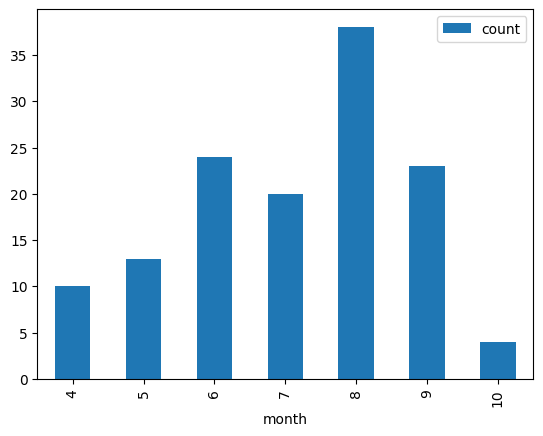

In [171]:
df[df["Nature"] == "Naturelle"].groupby(by="month").agg({"Année" : "count"}).rename(columns={"Année": "count"}).plot(kind="bar")